In [7]:
import mlflow
import os
from typing import Dict
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display


In [2]:
%%script bash --bg
mlflow server

In [3]:
tracking_uri = "http://127.0.0.1:5000"
mlflow.set_tracking_uri(tracking_uri)

In [4]:
experiment = mlflow.set_experiment("udacity")

2025/03/05 22:14:25 INFO mlflow.tracking.fluent: Experiment with name 'udacity' does not exist. Creating a new experiment.


In [5]:
@mlflow.trace
def add(a, b):
    return a + b

In [6]:
add(1, 2)

3

Trace(request_id=4897bebbed08413daf35caba73af050a)

**Logging Traces**

In [9]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [10]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

In [11]:
class State(MessagesState):
    question: str
    answer: str

In [12]:
llm_with_tools = llm.bind_tools([web_search])

In [13]:
def entry_point(state: State):
    question = state["question"]
    system_message = SystemMessage("You conduct web search to respond to user's questions")
    human_message = HumanMessage(question)
    messages = [system_message, human_message]
    return {"messages": messages}


In [14]:
def agent(state: State):
    messages = state["messages"]
    ai_message = llm_with_tools.invoke(messages)
    return {"messages": ai_message, "answer": ai_message.content}


In [15]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [16]:
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([web_search]))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")
workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)
workflow.add_edge("tools", "agent")

In [17]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["tools"], 
    checkpointer=memory
)

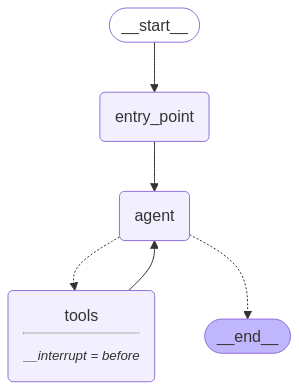

In [19]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [20]:
mlflow.langchain.autolog()

In [21]:
input_question = {"question": "what's the capital of Brazil?"}
config = {"configurable": {"thread_id": 1}}

In [22]:
for event in graph.stream(input=input_question, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_IvAS2tdTWWiI3nOLK1a5L8CN)
 Call ID: call_IvAS2tdTWWiI3nOLK1a5L8CN
  Args:
    question: capital of Brazil


Trace(request_id=1ca5e9083de04820b1ebd95d6d6be576)

In [23]:
state = graph.get_state(config=config)

In [24]:
state.next

('tools',)

In [25]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (call_IvAS2tdTWWiI3nOLK1a5L8CN)
 Call ID: call_IvAS2tdTWWiI3nOLK1a5L8CN
  Args:
    question: capital of Brazil
================================= Tool Message =================================
Name: web_search

{"query": "capital of Brazil", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is the Capital of Brazil? - Mappr", "url": "https://www.mappr.co/capital-cities/brazil/", "content": "Brasília is the capital of Brazil. Brazil has an interesting story when it comes to its capital city and the cities that are most important in the country. The current federal capital of Brazil is Brasília, which took the place of Rio de Janeiro as the government wanted to move the capital to a more central location. It is considered the cultural capital of Brazil and is one of the most populous cities in the world with over 30 million inhabitants. When did B

Trace(request_id=b311399fdc484c1dbbecab86c39a993b)

In [ ]:
# You can kill the server by running: 
# !kill -9 $(lsof -ti:5000)